In [1]:
%matplotlib inline
import pylab as pl

In [2]:
from astropy import units as u

In [3]:
from astropy.table import Table

In [4]:
import imf

In [5]:
import glob

# Load Robitaille 2017 -> Richardson 2023 Model Grid

### Theo's classification downselection

 * MS: 0 (below) / 1 (on/above) / -1 (too cold)
 * Stage: 0 (0) / 1 (I) / 2 (II) / 3 (III) / -1 (none)
 * Class: 0 (0) / 1 (I) / 2 (Flat) / 3 (II) / 4 (III) / -1 (none)

In [6]:
pars = Table.read('/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/s---s-i/parameters.fits')

In [7]:
path='/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/s---s-i/convolved/JWST/'

In [8]:
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/*/')
         if x.split("/")[-2].startswith('s')]

In [9]:
augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geom}_augmented.fits')
                for geom in geoms}
for key in augpars_dict:
    augpars_dict[key].add_index("MODEL_NAME")

In [10]:
classification_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/real_models/{geom}.fits')
                       for geom in geoms}
for key in classification_dict:
    classification_dict[key].add_index("Model Name")

In [11]:
import numpy as np
import regions
import warnings
import glob
from astropy.io import fits
from astropy import stats
import pylab as pl
from astropy import units as u
from grid_strategy import strategies
from astropy.table import Table
from astropy import wcs
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import itertools
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC,D22_MWAvg
from dust_extinction.parameter_averages import CCM89
from grid_strategy import strategies

sqgrid = strategies.SquareStrategy()
rectgrid = strategies.RectangularStrategy()


In [12]:
filters = [x for x in glob.glob(f'{path}/*fits') if 'NIRISS' not in x and not ('NIRCam' in x and 'W.fits' in x)]

In [13]:
filters = [x for x in glob.glob(f'{path}/*fits') if 'NIRISS' not in x and not ('NIRCam' in x and 'W.fits' in x)]
mfilters = [x for x in glob.glob(f'{path}/MIRI*fits') if 'W.fits' in x]
nfilters = [x for x in glob.glob(f'{path}/NIR*fits')]
colors = list(itertools.combinations(mfilters, 2))
combos = list(itertools.combinations(colors, 2))
gridspec = sqgrid.get_grid(len(combos))
print(len(combos), len(colors))

630 36


<Figure size 640x480 with 0 Axes>

## Population Synthesis step

In [14]:
mean_mass = (imf.kroupa.m_integrate(0.03, 120)[0] / imf.kroupa.integrate(0.03, 120)[0])*u.M_sun
mean_mass

<Quantity 0.43392936 solMass>

In [15]:
massfrac_above_4msun = imf.kroupa.m_integrate(4, 120)[0] / imf.kroupa.m_integrate(0.03, 120)[0]
massfrac_above_4msun

0.29639934520306555

In [16]:
massfrac_above_O = imf.kroupa.m_integrate(15, 120)[0] / imf.kroupa.m_integrate(0.03, 120)[0]
massfrac_above_O 

0.1446864366317716

In [17]:
meanmass_above_4msun = (imf.kroupa.m_integrate(4, 120)[0] / imf.kroupa.integrate(4, 120)[0])*u.M_sun
meanmass_above_4msun

<Quantity 11.22008088 solMass>

In [18]:
# W51A SFR based on Okumura00
# O star formation rate ~900Msun/Myr
sfr = 900*u.M_sun / u.Myr /massfrac_above_O
t_stage0 = 0.1*u.Myr
t_stage1 = 0.5*u.Myr
t_stage2 = 5.0*u.Myr
M_stage0 = t_stage0 * sfr
M_stage1 = t_stage1 * sfr
M_stage2 = t_stage2 * sfr


In [19]:
M_stage0.to(u.Msun), M_stage1.to(u.Msun), M_stage2.to(u.Msun), (M_stage0+M_stage1+M_stage2).to(u.Msun)

(<Quantity 622.03480917 solMass>,
 <Quantity 3110.17404586 solMass>,
 <Quantity 31101.74045859 solMass>,
 <Quantity 34833.94931362 solMass>)

In [20]:
nysos_stage0 = (M_stage0 * massfrac_above_4msun / meanmass_above_4msun).decompose()
nysos_stage1 = (M_stage1 * massfrac_above_4msun / meanmass_above_4msun).decompose()
nysos_stage2 = (M_stage2 * massfrac_above_4msun / meanmass_above_4msun).decompose()

In [21]:
nysos_stage0, nysos_stage1, nysos_stage2

(<Quantity 16.43220865>, <Quantity 82.16104327>, <Quantity 821.61043268>)

In [22]:
massfrac_0p5to4 = imf.kroupa.m_integrate(0.5, 4)[0] / imf.kroupa.m_integrate(0.03, 120)[0]
massfrac_0p5to4

0.40138782691744

In [23]:
meanmass_0p5to4 = (imf.kroupa.m_integrate(0.5, 4)[0] / imf.kroupa.integrate(0.5, 4)[0])*u.M_sun
meanmass_0p5to4

<Quantity 1.07777437 solMass>

In [24]:
nysos_lowmass_stage0 = (M_stage0 * massfrac_0p5to4 / meanmass_0p5to4).decompose()
nysos_lowmass_stage1 = (M_stage1 * massfrac_0p5to4 / meanmass_0p5to4).decompose()
nysos_lowmass_stage2 = (M_stage2 * massfrac_0p5to4 / meanmass_0p5to4).decompose()
nysos_lowmass_stage0, nysos_lowmass_stage1, nysos_lowmass_stage2

(<Quantity 231.65999006>, <Quantity 1158.29995029>, <Quantity 11582.99950287>)

## Synthetic Populations

In [25]:
st0stars = imf.make_cluster(M_stage0 * massfrac_above_4msun, massfunc=imf.Salpeter(mmin=4))
st1stars = imf.make_cluster(M_stage1 * massfrac_above_4msun, massfunc=imf.Salpeter(mmin=4))
st2stars = imf.make_cluster(M_stage2 * massfrac_above_4msun, massfunc=imf.Salpeter(mmin=4))

Total cluster mass is 177.676 (limit was 184.371)
Total cluster mass is 925.67 (limit was 921.854)
Total cluster mass is 9242.92 (limit was 9218.54)


In [26]:
# assume simple L = M^3 relation
st0stars_L = st0stars**3
st1stars_L = st1stars**3
st2stars_L = st2stars**3

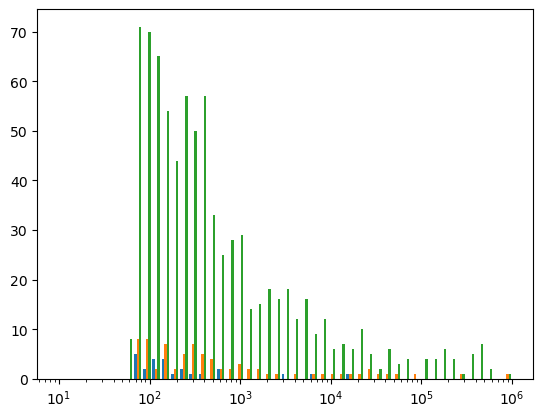

In [27]:
pl.hist([st0stars_L, st1stars_L, st2stars_L], bins=np.logspace(1,6))
pl.semilogx();

In [28]:
geoms

['s---s-i',
 's-pbsmi',
 's-p-hmi',
 'spu-hmi',
 'spubsmi',
 's-pbhmi',
 's-u-smi',
 's-ubhmi',
 'spu-smi',
 's-u-hmi',
 's-ubsmi',
 'sp--hmi',
 'sp--s-i',
 'spubhmi',
 's---smi',
 'sp--smi',
 's-p-smi',
 'sp--h-i']

In [29]:
geom = 'spubhmi'

In [30]:
# Some models do not produce finite fluxes in the specified apertures
color1 = keys1 = 'NIRCam.F212N', 'NIRCam.F480M',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
print(tbs['NIRCam.F212N']['TOTAL_FLUX'][:, 5])
isfinite = np.all([np.isfinite(tbs[key]['TOTAL_FLUX'][:, 5]) & ~(tbs[key]['TOTAL_FLUX'][:, 5]).mask
                   for key in keys1], axis=0)
isfinite.sum() / isfinite.size

      TOTAL_FLUX      
         mJy          
----------------------
     3267.529052734375
     3160.625244140625
     2965.133544921875
     2886.800048828125
       2638.1201171875
      2333.87353515625
    1962.5843505859375
     1778.031005859375
      1630.69287109375
     1.096375823020935
    1.1649107933044434
    1.3368853330612183
                   ...
3.8874062302518553e-10
 7.634931749322948e-12
 1.401298464324817e-45
                    --
  0.005886861123144627
  0.006044373381882906
  0.006092884577810764
  0.006131908856332302
  0.002908777678385377
  0.002449526684358716
  0.002182715805247426
 0.0017370159039273858
 0.0007118473295122385
Length = 720000 rows


0.7680125

In [31]:
(classification_dict[geom]['Stage'] == 0).sum(),  ((classification_dict[geom]['Stage'] == 0) & isfinite).sum(), isfinite.sum()

(91993, 41276, 552969)

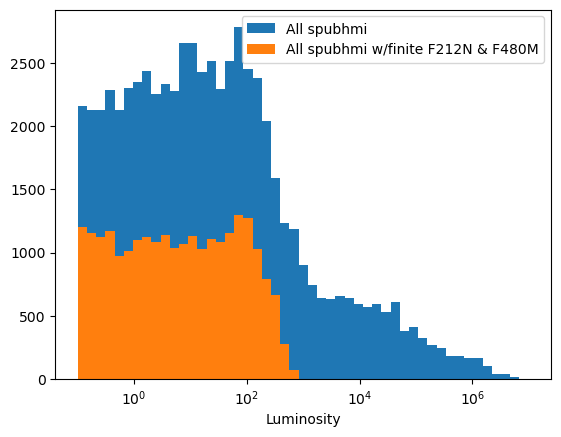

In [32]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0)]
pl.hist(pars['Model Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom}');
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0) & isfinite]
pl.hist(pars['Model Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom} w/finite F212N & F480M');
pl.semilogx();
pl.xlabel("Luminosity")
pl.legend(loc='best')

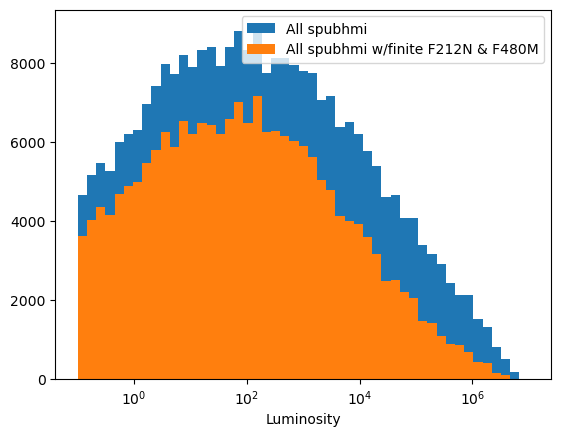

In [33]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 1)]
pl.hist(pars['Model Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom}');
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 1) & isfinite]
pl.hist(pars['Model Luminosity'], bins=np.logspace(-1, 7), label=f'All {geom} w/finite F212N & F480M');
pl.semilogx();
pl.xlabel("Luminosity")
pl.legend(loc='best')

# Bad hack time here:

`if(any())` in this code means there are stars that are just straight up not included in our model grid - there are no predictions for their JWST fluxes even though they are real models.

In [34]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 0) & isfinite]
st0models = [np.random.choice(pars['MODEL_NAME'][(0.9 * L < pars['Model Luminosity']) &
                                                 (pars['Model Luminosity'] < 1.1 * L)])
             for L in st0stars_L
            if any((0.9 * L < pars['Model Luminosity']) &
                                                 (pars['Model Luminosity'] < 1.1 * L))]

In [35]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 1) & isfinite]
st1models = [np.random.choice(pars['MODEL_NAME'][(0.9 * L < pars['Model Luminosity']) &
                                                 (pars['Model Luminosity'] < 1.1 * L)])
             for L in st1stars_L 
             if any((0.9 * L < pars['Model Luminosity']) &
                                                 (pars['Model Luminosity'] < 1.1 * L))
            ]

In [36]:
pars = augpars_dict[geom][(classification_dict[geom]['Stage'] == 2) & isfinite]
st2models = [np.random.choice(pars['MODEL_NAME'][(0.9 * L < pars['Model Luminosity']) &
                                                 (pars['Model Luminosity'] < 1.1 * L)])
             for L in st2stars_L 
             if any((0.9 * L < pars['Model Luminosity']) &
                                                 (pars['Model Luminosity'] < 1.1 * L))
            ]

In [37]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg, D22_MWAvg,CT06_MWLoc
from dust_extinction.parameter_averages import CCM89
ext = CT06_MWLoc()


In [38]:
from astroquery.svo_fps import SvoFps

In [39]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [40]:
distance_modulus = 5 * np.log10(540)
distance_modulus

13.661968799114844

In [41]:
basepath = '/orange/adamginsburg/jwst/brick/'
mist = Table.read(f'{basepath}/isochrones/MIST_iso_633a08f2d8bb1.iso.cmd',
                  header_start=12, data_start=13, format='ascii', delimiter=' ', comment='#')

In [42]:
av=30
filters = ['F162M', 'F182M', 'F187N','F210M', 'F335M', 'F360M', 'F405N','F410M', 'F480M']
agesel = mist['log10_isochrone_age_yr'] == 6
wavelength = []
fluxes = []
for filter in filters:
    filter2 = 'NIRCam.'+filter
    masssel =np.argmin(np.abs(mist['initial_mass'][agesel] - 1))
    wl_um = int(filter[1:4])*u.um/100

    extcol = av * ext(wl_um)

    mag = mist[filter][agesel][masssel]+distance_modulus+extcol
    print(filter2)
    flux =  (10**(-mag/2.5)*jfilts.loc['JWST/'+filter2]['ZeroPoint']*u.Jy).to(u.mJy)
    wavelength.append(wl_um.value)
    fluxes.append(flux.value)
    print(filter, mag, mist['initial_mass'][agesel][masssel])
    print(flux)
arr = np.vstack((wavelength,fluxes)).T
np.savetxt('mist_nircam_1Myr.dat', arr, newline='\n', delimiter=' ')


NIRCam.F162M
F162M 20.896505873188914 0.9883358878246498
0.004480119992695782 mJy
NIRCam.F182M
F182M 19.82946433757638 0.9883358878246498
0.009886483089346957 mJy
NIRCam.F187N
F187N 19.60027067612019 0.9883358878246498
0.01148618752654523 mJy
NIRCam.F210M
F210M 18.894455999114843 0.9883358878246498
0.01904699914388173 mJy
NIRCam.F335M
F335M 17.312882342398424 0.9883358878246498
0.035513002581907094 mJy
NIRCam.F360M
F360M 17.182755199114844 0.9883358878246498
0.03486445782152872 mJy
NIRCam.F405N
F405N 17.073635599114844 0.9883358878246498
0.030651511754245835 mJy
NIRCam.F410M
F410M 16.994888784480697 0.9883358878246498
0.03324083371515336 mJy
NIRCam.F480M
F480M 16.962092799114842 0.9883358878246498
0.02514718270627634 mJy


In [43]:
filters = ['F162M', 'F182M', 'F187N','F210M', 'F335M', 'F360M', 'F405N','F410M', 'F480M']
agesel = mist['log10_isochrone_age_yr'] == 6
wavelength = []
fluxes = []
for filter in filters:
    filter2 = 'NIRCam.'+filter
    masssel =np.argmin(np.abs(mist['initial_mass'][agesel] - 0.1))
    wl_um = int(filter[1:4])*u.um/100

    extcol = av * ext(wl_um)

    mag = mist[filter][agesel][masssel]+distance_modulus+extcol
    print(filter2)
    flux =  (10**(-mag/2.5)*jfilts.loc['JWST/'+filter2]['ZeroPoint']*u.Jy).to(u.mJy)
    wavelength.append(wl_um.value)
    fluxes.append(flux.value)
    print(filter, mag, mist['initial_mass'][agesel][masssel])
    print(flux)
arr = np.vstack((wavelength,fluxes)).T
np.savetxt('mist_nircam_01msun.dat', arr, newline='\n', delimiter=' ')


NIRCam.F162M
F162M 24.040023873188918 0.1
0.00024767515646420915 mJy
NIRCam.F182M
F182M 23.13781133757638 0.1
0.0004695729031269411 mJy
NIRCam.F187N
F187N 23.00122967612019 0.1
0.0005009476024610424 mJy
NIRCam.F210M
F210M 22.052464999114846 0.1
0.00103901773901427 mJy
NIRCam.F335M
F335M 20.231156342398425 0.1
0.0024158935422535226 mJy
NIRCam.F360M
F360M 19.90134319911484 0.1
0.002850675057859584 mJy
NIRCam.F405N
F405N 19.690186599114842 0.1
0.0027531603038239835 mJy
NIRCam.F410M
F410M 19.604368784480698 0.1
0.0030052451698679666 mJy
NIRCam.F480M
F480M 19.574823799114846 0.1
0.002266715096975799 mJy


In [44]:
filters = ['F162M', 'F182M', 'F187N','F210M', 'F335M', 'F360M', 'F405N','F410M', 'F480M']
agesel = mist['log10_isochrone_age_yr'] == 6
wavelength = []
fluxes = []
for filter in filters:
    filter2 = 'NIRCam.'+filter
    masssel =np.argmin(np.abs(mist['initial_mass'][agesel] - 4))
    wl_um = int(filter[1:4])*u.um/100

    extcol = av * ext(wl_um)

    mag = mist[filter][agesel][masssel]+distance_modulus+extcol
    print(filter2)
    flux =  (10**(-mag/2.5)*jfilts.loc['JWST/'+filter2]['ZeroPoint']*u.Jy).to(u.mJy)
    wavelength.append(wl_um.value)
    fluxes.append(flux.value)
    print(filter, mag, mist['initial_mass'][agesel][masssel])
    print(flux)
arr = np.vstack((wavelength,fluxes)).T
np.savetxt('mist_nircam_4msun.dat', arr, newline='\n', delimiter=' ')


NIRCam.F162M
F162M 18.093538873188916 4.000402760200936
0.05922109674207204 mJy
NIRCam.F182M
F182M 17.097107337576382 4.000402760200936
0.12245728538865804 mJy
NIRCam.F187N
F187N 16.895542676120193 4.000402760200936
0.1386970111694483 mJy
NIRCam.F210M
F210M 16.198212999114844 4.000402760200936
0.228204267844659 mJy
NIRCam.F335M
F335M 14.662123342398424 4.000402760200936
0.4080289642697733 mJy
NIRCam.F360M
F360M 14.537336199114844 4.000402760200936
0.3986121350146565 mJy
NIRCam.F405N
F405N 14.447855599114844 4.000402760200936
0.3441627784077971 mJy
NIRCam.F410M
F410M 14.353050784480697 4.000402760200936
0.37879750326400935 mJy
NIRCam.F480M
F480M 14.200858799114844 4.000402760200936
0.3198769431912835 mJy


0.9300808906555176
0.08641171455383301
22
76
805
0.002641439437866211
0.005823612213134766
0.050728559494018555
0.0008497238159179688
     TOTAL_FLUX    
        mJy        
-------------------
 0.7462634490937035
                 --
                 --
  4.993054777581589
 1.3846606035133897
                 --
                 --
 13.632264630621474
                 --
0.16781277401941383
0.49551070532340746
 2.5451166984969946
                 --
 0.5948694652534409
                 --
                 --
                 --
                 --
                 --
                 --
                 --
                 --
Stage 0, 22, 8, 22
     TOTAL_FLUX     
        mJy         
--------------------
                  --
                  --
                  --
                  --
                  --
                  --
                  --
                  --
                  --
                  --
  3.1269854480491133
                  --
                 ...
           

/scratch/local/13526413/ipykernel_1553622/569463890.py:40: RuntimeWarning: divide by zero encountered in log10
  colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
/scratch/local/13526413/ipykernel_1553622/569463890.py:41: RuntimeWarning: divide by zero encountered in log10
  2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
/scratch/local/13526413/ipykernel_1553622/569463890.py:42: RuntimeWarning: divide by zero encountered in log10
  colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))


     TOTAL_FLUX    
        mJy        
-------------------
                 --
                 --
-0.9650940323469073
                 --
-1.4886516719345892
                 --
                 --
 3.1677651886709333
 3.3858491257171153
                 --
   5.85538272949382
                 --
                ...
-0.6990719498578296
                 --
                 --
                 --
                 --
                 --
                 --
  1.816300834665544
                 --
                 --
                 --
-1.2612506528489142
                 --
Length = 805 rows
Stage 2, 805, 174, 805
0.10596084594726562
0.016749858856201172
(4, 10) (5.968435396226415, 13.423231396226415)


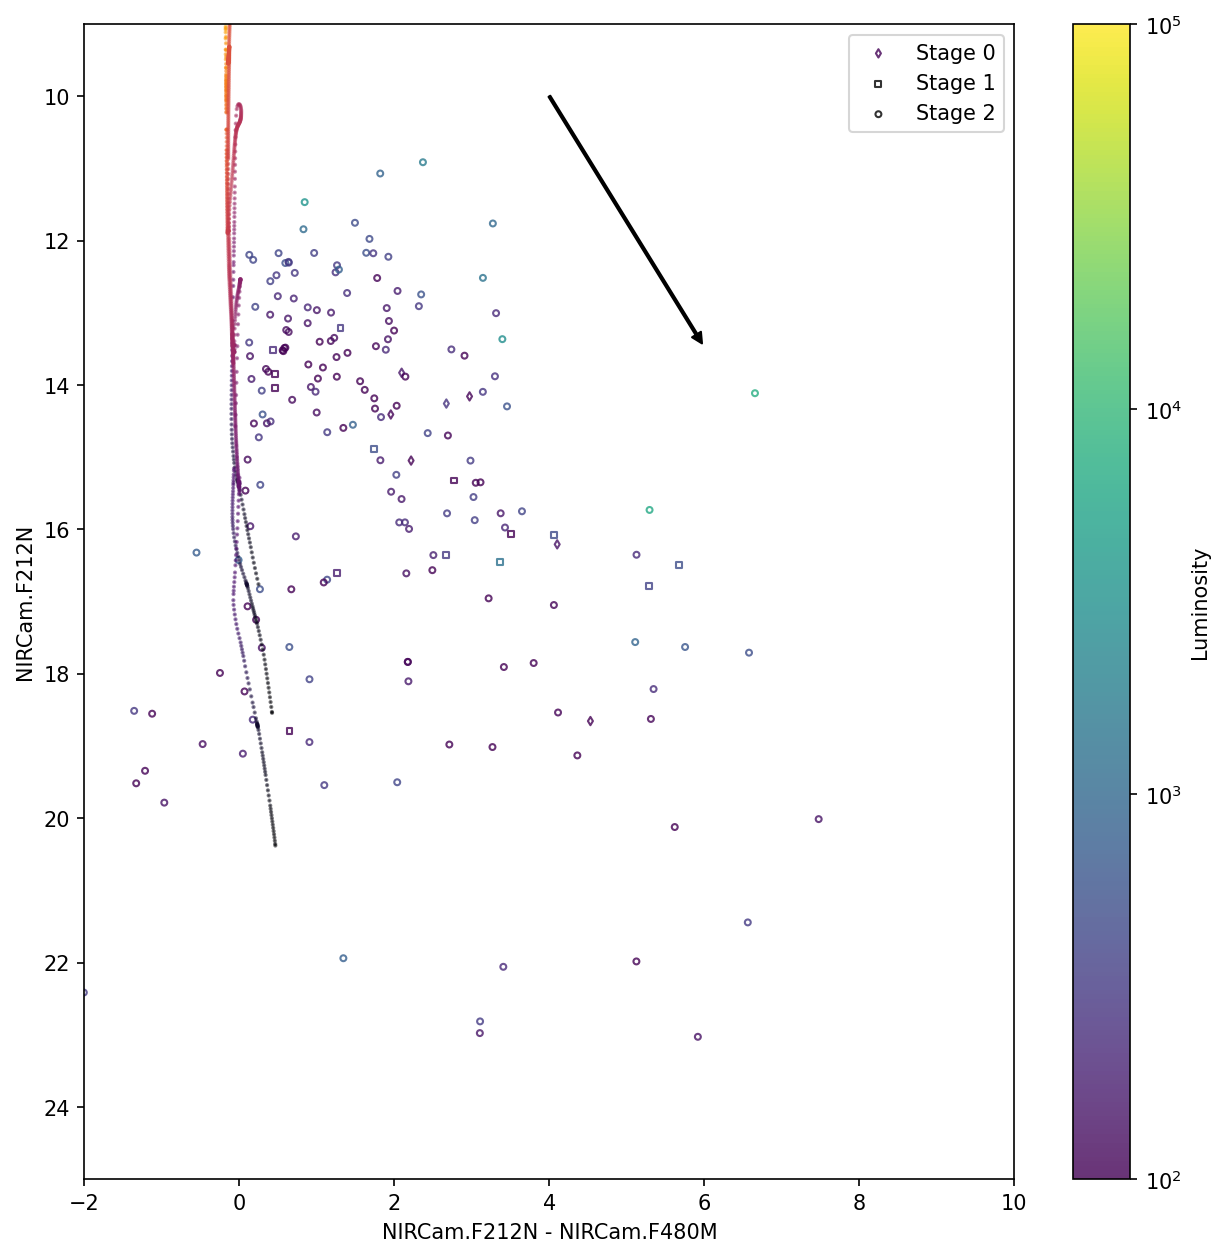

In [45]:
import time
start = time.time()
fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F212N', 'NIRCam.F480M',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
print(time.time()-start)
start = time.time()
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
print(time.time()-start)
print(len(np.array(st0models, dtype='unicode')))
print(len(np.array(st1models, dtype='unicode')))
print(len(np.array(st2models, dtype='unicode')))

start = time.time()
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]
print(time.time()-start)
start = time.time()
for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
   
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))
    print(colorp2)
    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Model Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
print(time.time()-start)
start=time.time()
    #ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,25,9))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F212N'][agesel]),
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

print(time.time()-start)
wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation.png", bbox_inches='tight')

0.2813682556152344
0.12421488761901855
22
76
805
0.0035228729248046875
0.00852823257446289
0.11102700233459473
0.00012183189392089844
    TOTAL_FLUX    
       mJy        
------------------
 6.571493094396306
3.0572770912322813
                --
 5.832790736232897
 4.931896692548432
 4.813234660654896
 6.695867634461455
 9.397771386034472
 3.081032949458783
3.0802619202697636
 4.303736317151991
 5.711522523235825
 6.147509071115352
 5.454354643746317
3.8757558676536146
10.049733139618777
14.202539802300194
10.008470929479639
2.9042529314845273
                --
 9.463727072195102
10.872511482154312
Stage 0, 22, 22, 22
    TOTAL_FLUX    
       mJy        
------------------
 7.600607008949943
    9.713618242968
19.022255849015572
12.733752664714574
 7.394992487965845
 9.721442509778447
 22.63067443417328
10.682193184457596
14.865683470417856
7.5240891842290765
 6.569402096562488
23.139986705324986
               ...
 6.733066753577538
13.108564983668636
16.553522313331534
 6.6108746

/scratch/local/13526413/ipykernel_1553622/2348492539.py:43: RuntimeWarning: divide by zero encountered in log10
  2.5*np.log10(tbs[keys1[2]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[2]]['ZeroPoint'], u.Jy)))
/scratch/local/13526413/ipykernel_1553622/2348492539.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  sc = ax.scatter(colorp1, colorp2, alpha=0.8,


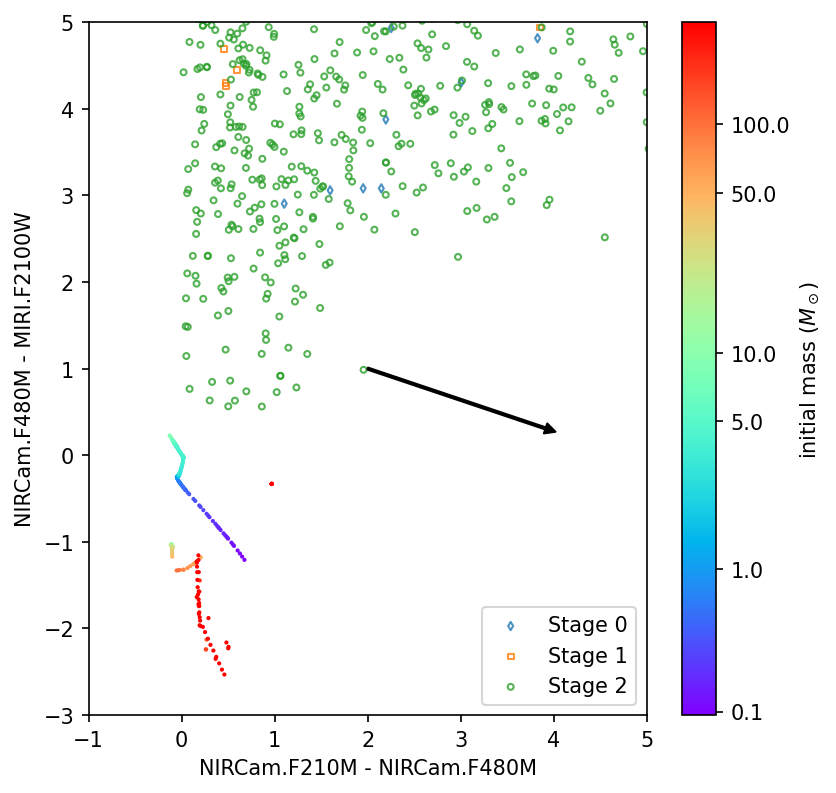

In [57]:
import time
start = time.time()
fig = pl.figure(figsize=(6, 6), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F210M', 'NIRCam.F480M', 'MIRI.F2100W'
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
print(time.time()-start)
start = time.time()
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
print(time.time()-start)
print(len(np.array(st0models, dtype='unicode')))
print(len(np.array(st1models, dtype='unicode')))
print(len(np.array(st2models, dtype='unicode')))

start = time.time()
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]
print(time.time()-start)
start = time.time()
for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
   
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[2]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[2]]['ZeroPoint'], u.Jy)))
    print(colorp2)
    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    #c=pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Model Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
print(time.time()-start)
start=time.time()
    #ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[1]} - {color1[2]}")
ax.axis((-1,5,-3,5))

homepath = '/home/t.yoo'
parsec_nircam = Table.read(f'{homepath}/iso_parsec_nircam.dat',
                format='ascii', delimiter=' ',)
parsec_miri = Table.read(f'{homepath}/iso_parsec_miri.dat',
                   format='ascii', delimiter=' ', comment='#')
norm = simple_norm(parsec_nircam['Mass'],stretch='log')
sc=pl.scatter(-(parsec_nircam['F480Mmag'] - parsec_nircam['F210Mmag']),
                   -(parsec_nircam['F210Mmag']-parsec_miri['F2100Wmag']),
                   c=parsec_nircam['Mini'],
                   norm=norm,
                   cmap='rainbow',
                   alpha=1,
                   s=1,
                  )

cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('initial mass ($M_\odot$)')
cb.set_ticks([0.1,1,5,10,50,100])
#cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])
wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
wl3_um = int(color1[2][-5:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * (ext(wl2_um) - ext(wl3_um))

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (2,1)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation.png", bbox_inches='tight')

In [ ]:
from astropy.table import Table, vstack
fig = pl.figure(figsize=(8, 8), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F162M',  'NIRCam.F187N','NIRCam.F210M','NIRCam.F335M','NIRCam.F360M','NIRCam.F405N','NIRCam.F410M','NIRCam.F480M', 'MIRI.F560W', 'MIRI.F770W', 'MIRI.F1000W', 'MIRI.F1280W', 'MIRI.F2100W' 
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]
mag_merged = {}
for key in keys1:
    
    wl_um = int(key[-4:-1])*u.um/100
    if key == 'MIRI.F1000W' or key== 'MIRI.F1280W' or key=='MIRI.F2100W':
        wl_um = int(key[-5:-1])*u.um/100

    mags = []
    for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):

        mag = -2.5*np.log10(tbs[key]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+key]['ZeroPoint'], u.Jy)) +  av * ext(wl_um) + distance_modulus
        magdata = np.ma.getdata(mag)
        mags+=list(magdata[magdata>-2.5])
        
        
        
    mag_merged[key] = mags
    
    ax.plot(np.sort(mags), np.arange(len(mags))/len(mags),label=key)
ax.legend()   
min_mag = [np.min(mag_merged[key]) for key in keys1]
mag_50 = [np.median(mag_merged[key]) for key in keys1]
mag_90 = [np.percentile(mag_merged[key],90) for key in keys1]
ax.set_xlim(30,3)
ax.set_ylabel('completeness',fontsize=20)
ax.set_xlabel('magnitude',fontsize=20)

print(min_mag, mag_50, mag_90)


In [ ]:
from astropy.table import Table, vstack
pars_st0 = [] ; pars_st1 = [] ; pars_st2 = []
for i, geom in enumerate(geoms):
    print(geom)
   
    color1 = keys1 = 'NIRCam.F070W','NIRCam.F090W','NIRCam.F115W','NIRCam.F162M', 'NIRCam.F187N','NIRCam.F210M','NIRCam.F277W','NIRCam.F335M','NIRCam.F360M','NIRCam.F405N','NIRCam.F410M','NIRCam.F480M', 'MIRI.F560W', 'MIRI.F770W', 'MIRI.F1000W', 'MIRI.F1280W', 'MIRI.F1500W','MIRI.F2100W','MIRI.F2550W' 

    augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geom}_augmented.fits')
                for geom in geoms}
    for key in augpars_dict:
        augpars_dict[key].add_index("MODEL_NAME")
    classification_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/real_models/{geom}.fits')
                       for geom in geoms}
    for key in classification_dict:
        classification_dict[key].add_index("Model Name")
        
    tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
           for cname in keys1}
  
    try:
        isfinite = np.all([np.isfinite(tbs[key]['TOTAL_FLUX'][:, 5]) & ~(tbs[key]['TOTAL_FLUX'][:, 5]).mask
                   for key in keys1], axis=0)
    except:
        isfinite = np.all([np.isfinite(tbs[key]['TOTAL_FLUX'][:, 5])
                   for key in keys1], axis=0)
    
    pars_st0 += augpars_dict[geom][(classification_dict[geom]['Stage'] == 0) & isfinite] 

    pars_st1 += augpars_dict[geom][(classification_dict[geom]['Stage'] == 1) & isfinite]

    pars_st2 += augpars_dict[geom][(classification_dict[geom]['Stage'] == 2) & isfinite]

pars_st0 = vstack(pars_st0)
print(len(pars_st0))
pars_st1 = vstack(pars_st1)
print(len(pars_st1))

pars_st2 = vstack(pars_st2)
print(len(pars_st2))

    
st0models = [np.random.choice(pars_st0['MODEL_NAME'][(0.9 * L < pars_st0['Model Luminosity']) &
                                                 (pars_st0['Model Luminosity'] < 1.1 * L)])
             for L in st0stars_L
            if any((0.9 * L < pars_st0['Model Luminosity']) &
                                                 (pars_st0['Model Luminosity'] < 1.1 * L))]
print(len(st0models))

st1models = [np.random.choice(pars_st1['MODEL_NAME'][(0.9 * L < pars_st1['Model Luminosity']) &
                                                 (pars_st1['Model Luminosity'] < 1.1 * L)])
             for L in st1stars_L 
             if any((0.9 * L < pars_st1['Model Luminosity']) &
                                                 (pars_st1['Model Luminosity'] < 1.1 * L))
            ]
print(len(st1models))

st2models = [np.random.choice(pars_st2['MODEL_NAME'][(0.9 * L < pars_st2['Model Luminosity']) &
                                                 (pars_st2['Model Luminosity'] < 1.1 * L)])
             for L in st2stars_L 
             if any((0.9 * L < pars_st2['Model Luminosity']) &
                                                 (pars_st2['Model Luminosity'] < 1.1 * L))
            ]
print(len(st2odels))

fig = pl.figure(figsize=(8, 8), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis


for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)


flux_merged = {}
wls=[]
for key in keys1:

    wl_um = int(key[-4:-1])*u.um/100
    if key == 'MIRI.F1000W' or key== 'MIRI.F1280W' or key=='MIRI.F2100W' or key=='MIRI.F1500W' or key=='MIRI.F2550W':
        wl_um = int(key[-5:-1])*u.um/100

    fluxs = []
    for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):

        flux = tbs[key]['TOTAL_FLUX'][:, 5]
        fluxdata = np.ma.getdata(flux)
        fluxs+=list(fluxdata[np.isfinite(fluxdata)])



    flux_merged[key] = fluxs
    wls.append(wl_um.value)

    ax.plot(np.sort(fluxs)[::-1], np.arange(len(fluxs))/len(fluxs),label=key)
ax.legend() 
ax.set_ylabel('completeness',fontsize=20)
ax.set_xlabel('flux (mJy)',fontsize=20)
ax.set_xscale('log')
ax.set_xlim(1e-2,1e7)
"""
flux_max = [np.max(flux_merged[key]) for key in keys1]
flux_10 = [np.percentile(flux_merged[key],90) for key in keys1]
flux_50 = [np.median(flux_merged[key]) for key in keys1]
flux_90 = [np.percentile(flux_merged[key],10) for key in keys1]

print(geom,flux_max,flux_10, flux_50, flux_90, wls)
plt.close()

if i ==0:
    flux_max_geoms = flux_max
    flux_10_geoms = flux_10
    flux_50_geoms = flux_50
    flux_90_geoms = flux_90
else:
    flux_max_geoms = np.vstack((flux_max_geoms,flux_max))
    flux_10_geoms = np.vstack((flux_10_geoms,flux_10))
    flux_50_geoms = np.vstack((flux_50_geoms,flux_50))
    flux_90_geoms = np.vstack((flux_90_geoms,flux_90))
        
flux_max_av = 10**np.mean(np.log10(flux_max_geoms),axis=1)
flux_10_av = 10**np.mean(np.log10(flux_10_geoms),axis=1)
flux_50_av = 10**np.mean(np.log10(flux_50_geoms),axis=1)
flux_90_av = 10**np.mean(np.log10(flux_90_geoms),axis=1)
print(flux_max_av, flux_10_av,flux_50_av,flux_90_av)

np.savetxt('YSO_flux_10.dat', np.vstack((wls, flux_10_av)), newline='\n', delimiter=' ')
np.savetxt('YSO_flux_50.dat', np.vstack((wls, flux_50_av)), newline='\n', delimiter=' ')
np.savetxt('YSO_flux_90.dat', np.vstack((wls, flux_90_av)), newline='\n', delimiter=' ')
np.savetxt('YSO_flux_max.dat', np.vstack((wls, flux_max_av)), newline='\n', delimiter=' ')
"""

In [ ]:
fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()
color1 = keys1 = 'NIRCam.F115W','NIRCam.F187N','NIRCam.F210M', 'NIRCam.F405N',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
start = time.time()
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)
start = time.time()
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}
print(time.time()-start)

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]
start = time.time()

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
   
    colorp1 = (-2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[3]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[3]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[2]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[2]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Model Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
print(time.time()-start)

#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-4,10,-4,10))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e0,1e1,1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (0,1,2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F405N'][agesel] - mist['F187N'][agesel]),
                   -(mist['F210M'][agesel] - mist['F115W'][agesel]),
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
wl3_um = int(color1[2][-4:-1])*u.um/100
wl4_um = int(color1[3][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
extcol1 = av * (ext(wl2_um) - ext(wl4_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * (ext(wl1_um) - ext(wl3_um))

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_CCD.png", bbox_inches='tight')

The plot above includes only "stagified" sources, which means they should be at least semi-realistic (they pass _some_ cuts).

In [ ]:

fig = pl.figure(figsize=(10, 10), dpi=150)
ax = pl.gca()

av = 30

cmap = pl.cm.viridis

color1 = keys1 = 'NIRCam.F212N', 'NIRCam.F480M',
tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
       for cname in keys1}
for tb in tbs.values():
    tb.add_index('MODEL_NAME')
tbs0 = {key: val.loc[np.array(st0models, dtype='unicode')] for key, val in tbs.items()}
tbs1 = {key: val.loc[np.array(st1models, dtype='unicode')] for key, val in tbs.items()}
tbs2 = {key: val.loc[np.array(st2models, dtype='unicode')] for key, val in tbs.items()}

norm = simple_norm(np.hstack([st0stars_L, st1stars_L, st2stars_L]), stretch='log', min_cut=1e2, max_cut=1e5)

pars = augpars_dict[geom]

for tbs, stage, shape, luminosities, mods in zip((tbs0, tbs1, tbs2), (0, 1, 2), ('d', 's', 'o'), (st0stars_L, st1stars_L, st2stars_L), (st0models, st1models, st2models)):
    colorp1 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)) +
               2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[1]]['ZeroPoint'], u.Jy)))
    colorp2 = (-2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5] / u.Quantity(jfilts.loc['JWST/'+keys1[0]]['ZeroPoint'], u.Jy)))

    print(f"Stage {stage}, {len(colorp1)}, {np.isfinite(colorp1).sum()}, {np.isfinite(np.array(colorp2)).sum()}")#, {colorp1}, {colorp2}")
    sc = ax.scatter(colorp1, colorp2 + distance_modulus, alpha=0.8,
                    #c=[stage]*len(colorp2),
                    c=pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'],
                    norm=norm,
                    cmap=cmap,
                    marker=shape,
                    #facecolors='none',
                    #edgecolors=cmap(norm(pars.loc[np.array(mods, dtype='unicode')]['Model Luminosity'])),
                    s=8,
                    label=f'Stage {stage}',
                   )#(np.log10(augpars['Model Luminosity'])))
    pl.draw()
    facecolors = sc.get_facecolors()
    edgecolors = sc.get_edgecolors()
    sc.set_edgecolors(facecolors)
    sc.set_facecolors('none')
#ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
ax.set_xlabel(f"{color1[0]} - {color1[1]}")
ax.set_ylabel(f"{color1[0]}")
ax.axis((-2,10,25,9))
cb = pl.colorbar(mappable=sc, ax=ax)
cb.set_label('Luminosity')
cb.set_ticks([1e2, 1e3, 1e4, 1e5])
cb.set_ticklabels([f'$10^{x}$' for x in (2,3,4,5)])


norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(-(mist['F480M'][agesel] - mist['F212N'][agesel]),
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )


wl1_um = int(color1[0][-4:-1])*u.um/100
wl2_um = int(color1[1][-4:-1])*u.um/100
#wl3_um = int(color2[0][-4:-1])*u.um/100
#wl4_um = int(color2[1][-4:-1])*u.um/100
extcol1 = av * (ext(wl1_um) - ext(wl2_um))
#extcol2 = av * (ext(wl3_um) - ext(wl4_um))
extcol2 = av * ext(wl1_um)

leg = pl.legend(loc='best')
#for lh in leg.legend_handles:
#    lh.set_facecolors('k')
#    lh.set_edgecolor('k')

arrow_start = (4, 10)
arrow_end = (arrow_start[0] + extcol1, arrow_start[1] + extcol2)
print(arrow_start, arrow_end)
ax.annotate('', arrow_end, arrow_start,
    arrowprops=dict(width=1, headwidth=5, headlength=5,
    edgecolor='k',
    facecolor='k', ),
    color='k',
   );
pl.savefig("SynthesizedFullCMZYSOPopulation_withStageII.png", bbox_inches='tight')

In [ ]:
from astropy import constants, units as u

In [ ]:
Lacc = (constants.G * 5e-6*u.M_sun/u.yr * u.M_sun / u.R_sun).to(u.Lsun)
Lacc

In [ ]:
Lacc = (constants.G * 1e-5*u.M_sun/u.yr * u.M_sun / u.R_sun).to(u.Lsun)
Lacc